# Analysing the effect of resolution on the snowslide results

Nous avons observé dès les premières simulations de l’algorithme que l’utilisation de modèles topographiques identiques mais de résolutions différentes pouvaient donner des résultats divergents. Nous nous intéressons donc à la variabilité des solutions de sortie de Snowslide en fonction de modèles numériques de terrain de résolutions différentes. Nous opérons dans un premier temps sur des DEMs synthétiques puis nous testons l’effet de la résolution sur des DEM réels dans un second temps.

In [16]:
# Importations
import os
import rasterio 
import numpy as np 
import matplotlib.pyplot as plt
from snowslide import *
from snowslide import functions

from rasterio.windows import Window
from rasterio.enums import Resampling

from tqdm import tqdm
from snowslide.snowslide_main import snowslide_base
from snowslide.preprocess_data import *

In [4]:
# Choose your working directory
os.chdir("/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Tests_limites_ss")

## 0) Creation of synthetic digital elevation models

Afin de mener à bien ce travail, nous travaillerons essentiellement avec le dem linéaire avec rupture de pente qui est tout d'abord l'un des plus simple à générer et analyser. On définit donc dans un premier temps les fonctions qui nous permettrons de générer, de visualiser ou d'enregistrer ce type de dem afin de les réutiliser à notre guise dans la suite de ce notebook et selon les besoins d'analyse identifiés. 

In [5]:
# Creating linear dem 
def create_linear_dem():
    z1 = np.abs(np.arange(-75,-10,2.5))
    z2 = np.abs(np.arange(-(np.min(z1)-2.5),0,0.3))
    z = np.concatenate((z1,z2))

    dem = np.full((np.size(z),60),1.0)
    for i in range(np.shape(dem)[1]) :
        dem[:,i] = z
    dem=dem*10
    return dem

In [6]:
# Plotting dem to see the result
def plot3D(Z,elev=30,azim=30,figsize=(10,8),xlabel='x',ylabel='y',cmap='gray',title='') :
    # creating data
    shape = np.shape(Z)
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    X,Y = np.meshgrid(x,y)

    # creating plots
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    plt.title(title)
    
    # Réorienter la caméra
    ax.view_init(elev=elev, azim=azim)

    ax.plot_surface(X,Y,Z,cmap=cmap)
    #ax.set_zlabel('Altitude')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

In [7]:
# Storing the dem as a raster file with a specified resolution
def storing_dem(dem_path,dem,res=10) :
    profile = {'count': 1,'dtype': 'float64','height': dem.shape[0],'width': dem.shape[1],
        'crs': 'EPSG:4326','transform': rasterio.transform.from_origin(0, 0, res, res)}
    with rasterio.open(dem_path, 'w', **profile) as dst:
        dst.write(dem, 1)

Nous pouvons ensuite modifier la résolution du dem en utilisant la fonction resampling_dem créée dans le script preprocess_data.py associé au package. Cette modification se fait en indiquant le facteur choisi. Testons ces fonctions : 

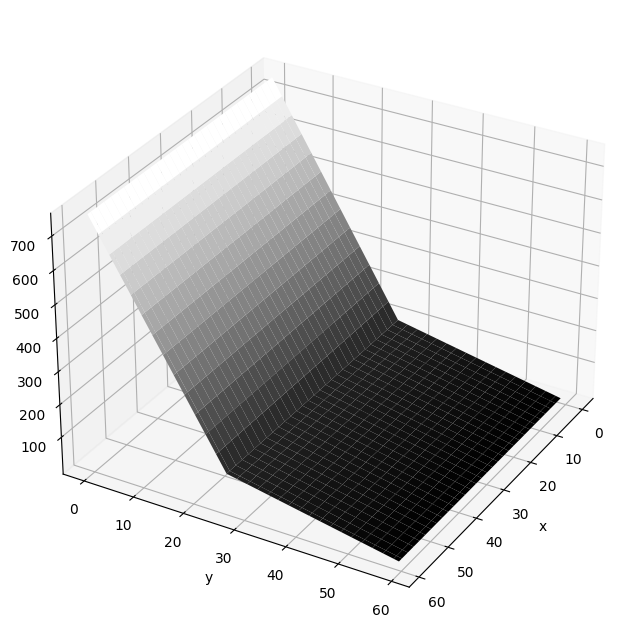

In [8]:
dem = create_linear_dem()
plot3D(dem)

In [11]:
dem_path = "DEM_linear_NorthFaces.tif"
storing_dem(dem_path,dem)

### 2) Création d'un nombre de dems nécessaires au travail

In [15]:
folder = 'Resolution_LinDems'
if not os.path.exists(folder):
    os.mkdir(folder)

In [22]:
resol = ["50.0","40.0","30.0","20.0","10.0","5.0","4.0","3.0","2.0","1.0"]
dem_paths = []
for elt in resol :
    # Creating path list 
    dst_path = folder + "/" + f"DEM_linear_NorthFaces_{elt}m.tif"
    dem_paths.append(dst_path)
    # generating dems
    factor=10/float(elt)
    resampling_dem(src_path=dem_path, dst_path=dst_path,factor=factor,resampling="bilinear")

/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [24]:
# srcs contains informations about the rasters as a list
srcs = []
for elt in dem_paths:
    srcs.append(rasterio.open(elt))

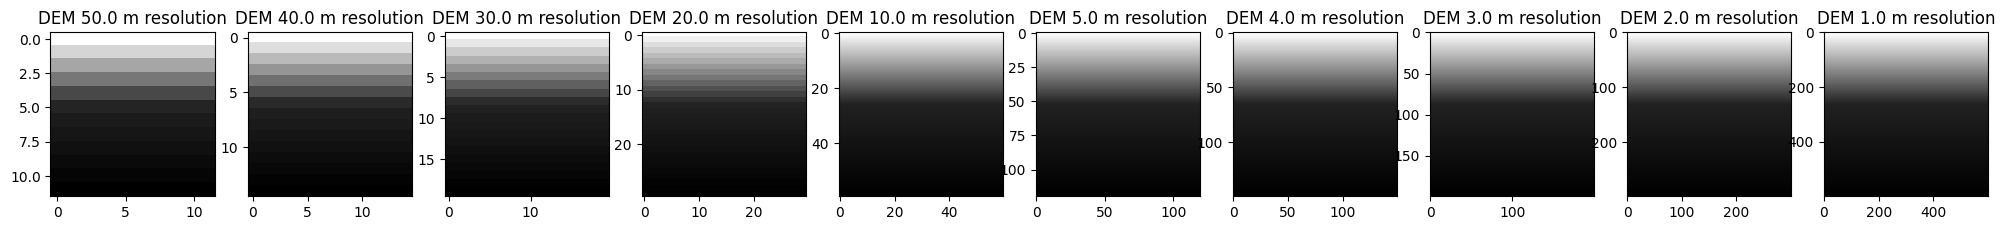

In [25]:
# Plotting code 
fig,ax = plt.subplots(1,len(dem_paths),figsize=(25,3))
for i in range(len(srcs)) :
    plot = ax[i].imshow(srcs[i].read(1),cmap='gray')
    ax[i].set_title(f"DEM {srcs[i].res[0]} m resolution")

### 2) Launching Snowslide simulations

A partir de la liste srcs on lance alors les simulations snowslide. On choisit également de stocker des statistiques sur les résultats afin d'en faciliter l'analyse : 
On considère comme un dépôt tout pixel dont la hauteur après convergence est supérieure strictement à la hauteur initiale de neige qui lui est associée. 
- deposit_area : Nombre de pixels associés à un dépôt x resolution 
- deposit_volume : Somme des pixels associés à un dépôt x résolution 
- max_height : Pixel d'un dépôt associé à la hauteur maximale
- deposit_max_distance : Longuer maximale du dépôt dans le sens des colonnes (nb de pixels x résolution)

In [26]:
from snowslide.snowslide_main import snowslide_base

# Launching snowslide on each dem
snds = []
snd_stats = []
statistics = []
for dem_path in tqdm(dem_paths, desc="Computation progress ", unit="dems"): # Un simple moyen d'afficher une progress_bar
    # Inputs
    init = 1.0
    dem = rasterio.open(dem_path).read(1)
    #SND0 = np.full(np.shape(dem),1.0)
    snd0 = np.zeros(np.shape(dem))
    snd0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True,"compute_edges":True}
    
    # Simulation
    snd = snowslide_base(dem_path,snd0,param_routing=param_routing)
    snds.append(snd)

    # Statistiques
    dic = {}
    snd_test = np.copy(snd)
    snd_test[np.where(snd <= snd0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(snd_test))*resolution**2
    dic["deposit_volume"] = np.nansum(snd_test)*resolution**2
    dic["max_height"] = np.nanmax(snd_test)
    indices_non_nan = np.where(~np.isnan(snd_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    snd_stats.append(snd_test)
    statistics.append(dic)

Computation progress :   0%|          | 0/10 [00:00<?, ?dems/s]/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
Computation progress :  10%|█         | 1/10 [00:00<00:01,  5.85dems/s]/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
Computation progre

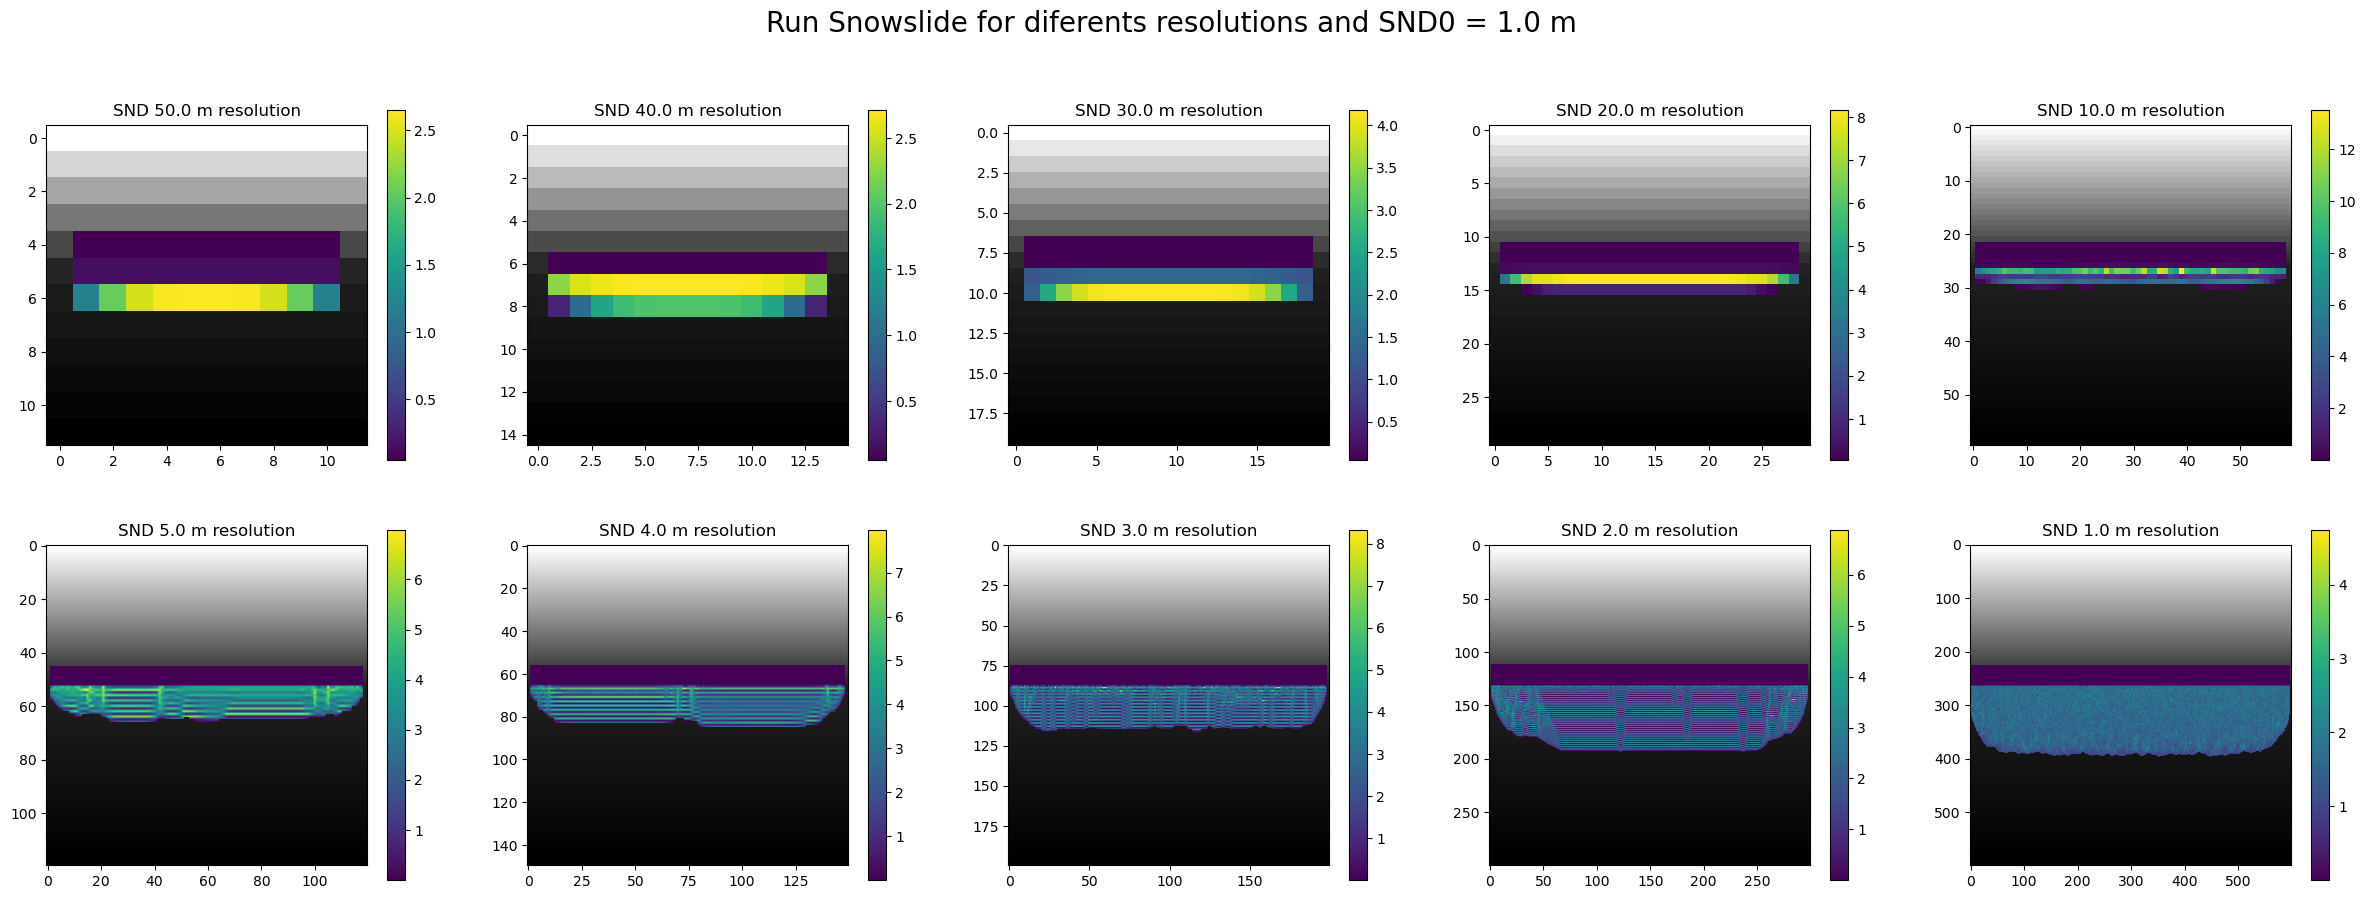

In [11]:
# Plotting code
fig,ax = plt.subplots(2,5,figsize=(30,10))
for i in range(5) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)

    ax[0,i].imshow(srcs[i].read(1),cmap='gray')
    plot = ax[0,i].imshow(snd_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    
    ax[1,i].imshow(srcs[i+5].read(1),cmap='gray')
    plot = ax[1,i].imshow(snd_stats[i+5])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+5].res[0]} m resolution")

Lorsqu’on regarde les dépôts d’avalanche de façon qualitative il semble que la résolution affecte de façon importante les résultats donnés par le modèle alors que le dem est topographiquement identique. On observe que pour les résolutions 50m et 20m, le dépôt se fait presque exclusivement sur une ligne de pixel soit une distance transverse de quelques dizaines de mètres. En revanche pour les résolutions plus fines, on constate que l’aire de dépôt se prolonge dans la pente à mesure que la résolution augmente jusqu’à atteindre un dépôt d’une distance transversale de près de 150m pour le dem résolu à 1m. C’est un résultat observé sur de nombreuses autres simulations et donc généralisable au fonctionnement de Snowslide : plus la résolution du dem augmente, plus les dépôts semblent se prolonger dans le sens de la pente. (Notons qu’on semble également observer une perte de symétrie). Nous pouvons vérifier ces conclusions qualitatives en affichant quelques graphiques sur les indicateurs précédemment calculés. 

In [27]:
# Calculating indicators 
areas = []
volumes = []
heights = []
total_volume = []
init_volume = []
resol_dems = []
for i in range(len(dem_paths)):
    SND0 = np.zeros(np.shape(srcs[i].read(1)))
    SND0[np.where(srcs[i].read(1) > 800)] = init
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    total_volume.append(np.sum(snds[i])*(srcs[i].res[0])**2)
    init_volume.append(np.sum(SND0)*(srcs[i].res[0])**2)
    
    resol_dems.append(str(srcs[i].res[0]))

Text(0.5, 1.0, 'Max heights on the dems')

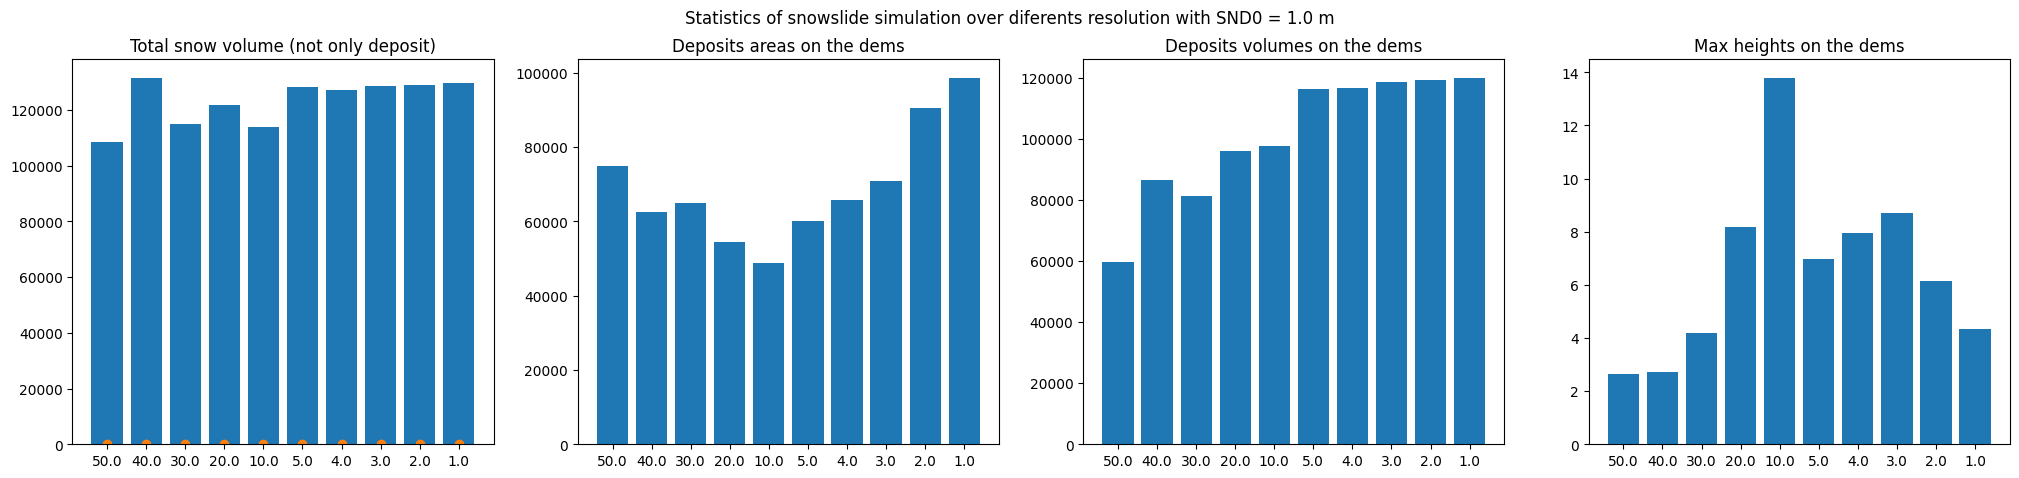

In [28]:
fig,ax = plt.subplots(1,4,figsize=(25,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,total_volume)
ax[0].scatter(resol_dems,init_volume)
ax[0].set_title('Total snow volume (not only deposit)')
ax[1].bar(resol_dems,areas)
ax[1].set_title('Deposits areas on the dems')
ax[2].bar(resol_dems,volumes)
ax[2].set_title('Deposits volumes on the dems')
ax[3].bar(resol_dems,heights)
ax[3].set_title('Max heights on the dems')

In [31]:
# Calculating maximal length deposit evolution with resolution 
deposit_length = []
for i in range(len(snd_stats)) :
    resolution = srcs[i].res[0]
    SND_test = snd_stats[i]
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    length = (max_index - min_index)*resolution
    deposit_length.append(length)

Text(0, 0.5, 'Deposit length (m)')

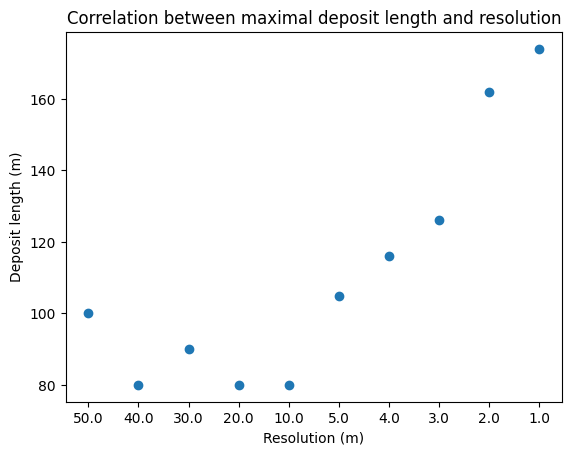

In [33]:
# Plotting code
plt.scatter(resol_dems,deposit_length)
plt.title("Correlation between maximal deposit length and resolution")
plt.xlabel("Resolution (m)")
plt.ylabel("Deposit length (m)")

Il semblerait qu'on identifie très franchement un lien entre distance moyenne du dépôt et résolution. En particulier, il semblerait que à des résolutions inférieures à 10m cela ne soit pas significatif mais que cela le devienne pour des résolutions supérieures à 10m. Cela pourrait valoir le coup d'approfondir ce lien en traçant ce même plot à partir de plus de données statistiques afin de vérifier l'existence de ces deux dynamiques différentes. 

### 3) Running snowslide with a lot of diferent resolutions for statistical analysis

In [34]:
# On créé un dossier avec plein de DEMs de résolution différente
resolutions = np.arange(1,60.5,0.5)
for res in resolutions :
    factor = 10/res
    dst_path = folder + f"/DEM_linear_NorthFaces_{res}m.tif"
    if not os.path.exists(dst_path): 
        resampling_dem(dem_path,dst_path,factor)

In [ ]:
# Listing elements in the folder
import os
if os.path.exists(folder) and os.path.isdir(folder):
    dem_paths = [os.path.join(folder, element) for element in os.listdir(folder)]

# launching snowslide on these dems
statistics = []
SND_tot = []
i = 0
for dem_path in dem_paths :
    # Inputs
    init = 1
    dem = rasterio.open(dem_path).read(1)

    snd0 = np.zeros(np.shape(dem))
    snd0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True,"compute_edges":True}
    
    # Simulation
    snd = snowslide_base(dem_path,snd0=snd0,param_routing=param_routing)
    SND_tot.append(snd)

    # Statistiques
    dic = {}
    SND_test = np.copy(snd)
    SND_test[np.where(snd <= snd0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    statistics.append(dic)
    i = i+1
    print(f"##### Complété : {(i/120)*100}%")


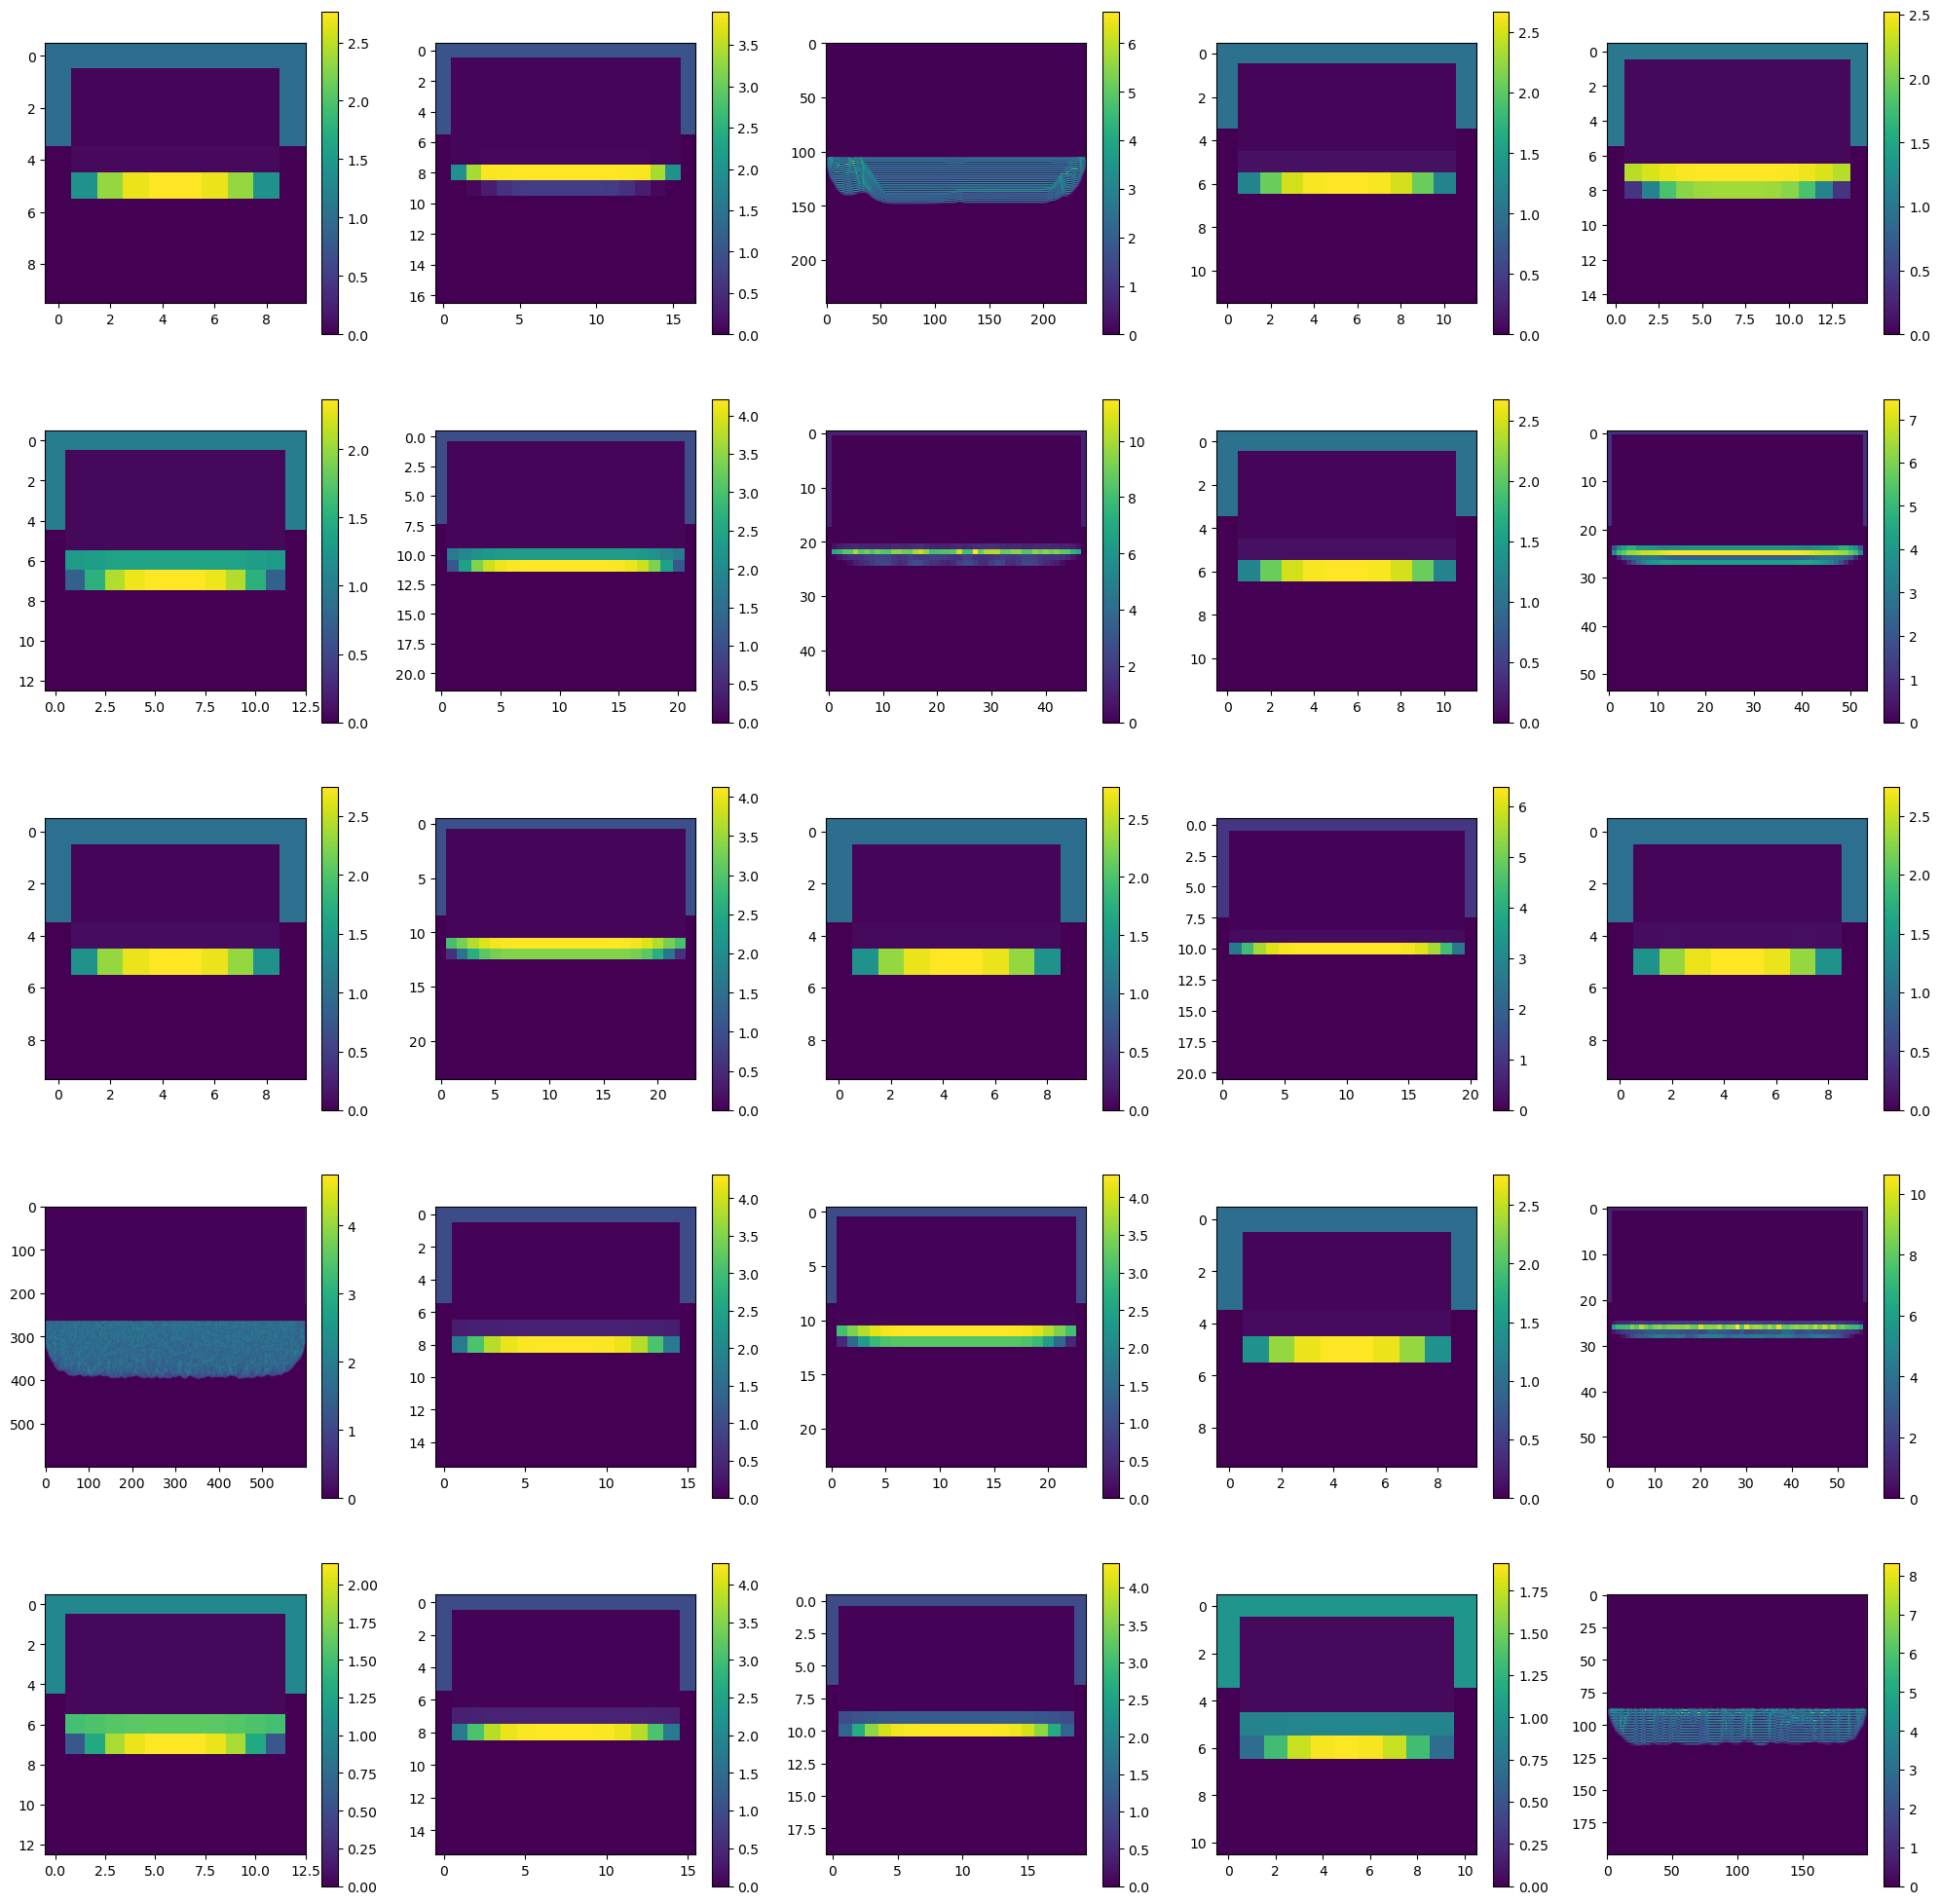

In [31]:
# # Visualisation of 25 first results (get sure it worked)
# fig,ax = plt.subplots(5,5,figsize=(25,25))
# iter = 0
# for i in range(5) :
#     for j in range(5) :
#         plot = ax[i,j].imshow(SND_tot[iter])
#         plt.colorbar(plot,ax=ax[i,j])
#         iter = iter + 1

Text(0.5, 1.0, 'Evolution de la longueur des dépôts selon la résolution')

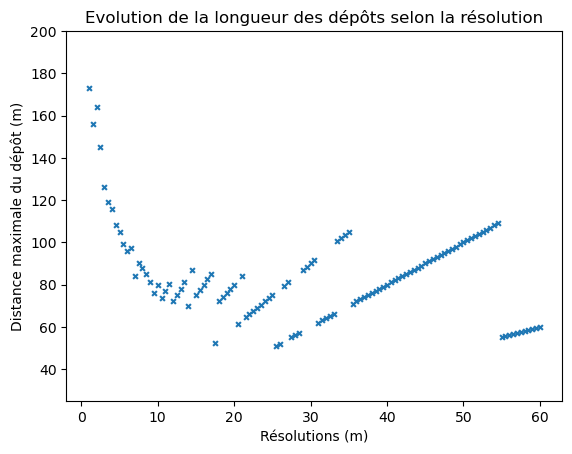

In [40]:
# Plotting statistics
x = []
y = []
for i in range(len(dem_paths)) :
    x.append(rasterio.open(dem_paths[i]).res[0])
    y.append(statistics[i]["deposit_max_distance"])
plt.scatter(x,y,marker="x",s=12)
plt.xlabel('Resolutions (m)')
plt.ylim(25,200) # Il y a une valeur aberrante à 4000
plt.ylabel('Maximal length of deposits (m)')
plt.title('Evolution of the maximal length deposit with resolution')

La figure précédente donne sur 120 simulations la relation statistique entre la résolution du dem utilisé et la distance maximale du dépôt identifiée. Cette distance maximale est calculée pour chaque dépôt à partir de la colonne pour laquelle le plus de pixels sont associés à une valeur de dépôt. Ce nombre de pixel est alors multiplié par la résolution pour obtenir une distance. Sur des résolutions supérieures à 10m (la résolution initiale du DEM) on observe des relations linéaires entre certaines gammes de résolution et les distances de dépôt. Ces relations linéaires sont dues au fait que pour une gamme de résolution relativement grossière (exemple entre 55m et 60m) la simulation produit des dépôts sur le même nombre de pixels mais la multiplication par la résolution pour obtenir une distance de dépôt « comparable » entraîne des différences de valeurs. Ces différences sont simplement proportionnelles aux différences de résolution d’où une relation logiquement linéaire. Pour des résolutions supérieures à 10m, on peut dire que la résolution affecte la distance maximale des dépôts (dans le sens de la pente) avec des variations pouvant aller jusqu’à un facteur 2. C’est un élément important que l’on doit avoir en tête lors de la modélisation, surtout que les résolutions supérieures à 10m sont généralement les résolutions avec lesquelles on travaille en sciences glaciologiques (de 10m à 100m). Ainsi pour des résolutions faibles, il existe une incertitude liée à l’approximation réalisée par la résolution. 
Ensuite, si l’on s’intéresse aux longueurs de dépôts pour des résolutions inférieures à 10m, on constate que que la distance de dépôt augmente fortement lorsque la résolution s’affine. Le tracé d’une régression linéaire pour des résolution inférieure à 10m donne un coefficient de 10, c’est-à-dire qu’en dessous de 10m de résolution, augmenter la résolution de 1m a tendance à augmenter la distance de dépôt d’au moins 10m (la relation étant plus exponentielle que véritablement linéaire ce qui augmente ce facteur pour les résolutions plus fines). Ce résultat semblerait indiquer qu’il ne faut pas se placer à une résolution inférieure à 10m

Notons que cet effet est compréhensible étant donné la construction de snowslide. La figure suivante permet de le comprendre : 

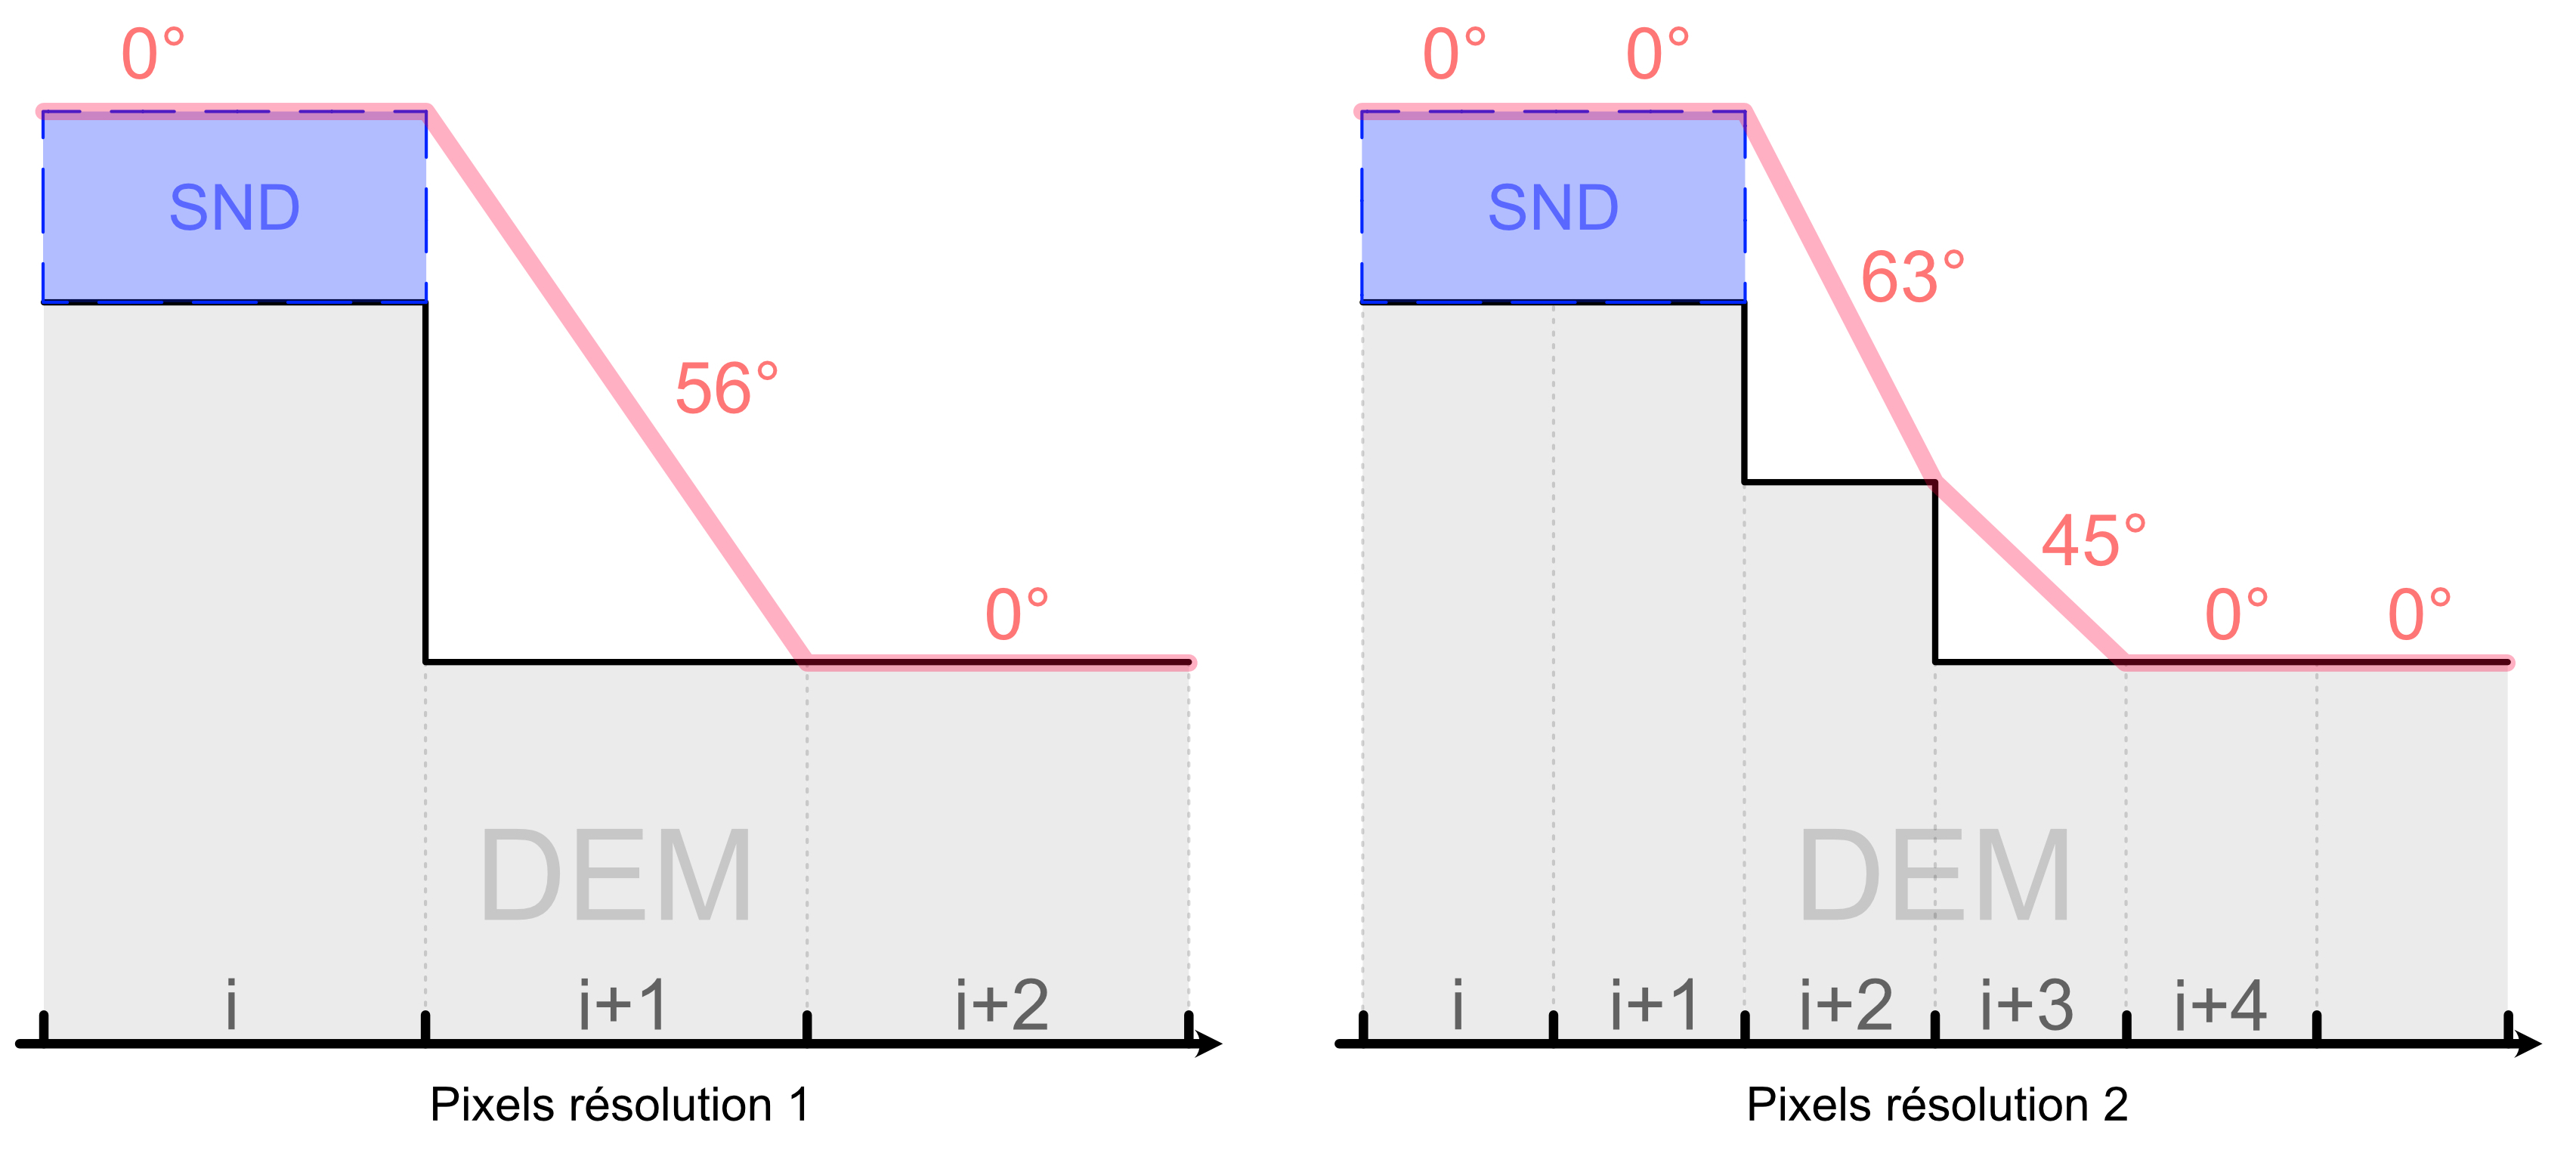

La figure donne une vision schématique du calcul de pente par Snowslide (si on se plaçait en 1D ce qui n’est pas le cas dans l’algorithme). On s’aperçoit alors que lorsque la résolution augmente, le calcul de la pente entre des pixels qui ont des hauteurs de neige associées différentes n’est pas strictement identique. En effet, pour une même hauteur de neige recouvrant un pixel amont, la pente calculée est plus importante si la résolution est plus faible. Si cela est compensé par la moyenne de la pente sur deux pixels, Snowslide ne route tout de même pas les mêmes quantités de neige dans les deux cas puisqu’ayant affaire à une pente différente, et plus la pente calculée est raide, plus Snowslide aura tendance à router une grande quantité de neige. On comprend alors qu’après plusieurs itérations, les résultats pour une même quantité de neige mais des résolutions différentes divergent. Ainsi, ce n’est pas tant pour un seuil de résolution que Snowslide présentera des résultats divergents et aberrants, mais c’est pour un rapport entre quantité initiale de neige et résolution. C’est un effet qui a tendance à ne plus être prépondérant lorsque la hauteur de neige est faible devant la taille des pixels (les différences de pente calculées sont alors négligeables) d’où des distances de dépôt qui se stabilisent dans une gamme commune pour les résolutions supérieures à 10m.

### 3) Running snowslide with a lot of diferent resolutions and diferents initial snow heights for statistical analysis

On choisit de pousser notre analyse en recommançant l'expérience pour différentes hauteurs initiales. En effet les analyses ont montré que ce qui semblait importer était le ratio hauteur initiale sur resolution. (snd0/resolution). 
Pour cela, l'utilisateur peut run à plusieurs reprises les codes de la section 2 puis sauver les résultats statistiques dans un tableau numpy comme proposé dans la ligne de code suivante. Nous proposons de tester les hauteurs initiales suivantes : 
- 0.2m 
- 0.5m
- 1.0m
- 2.0m 
- 3.0m

In [35]:
folder2 = 'Statistics'
if not os.path.exists(folder2):
    os.mkdir(folder2)

# The user must modify the name according to the initial snow height chosen
name = "/fct_dist_resol_SND1.0.npy"
array = np.array([x,y])
path = folder2 + name
np.save(path,array)

NameError: name 'x' is not defined

#### Affichage de tous les graphes ensembles

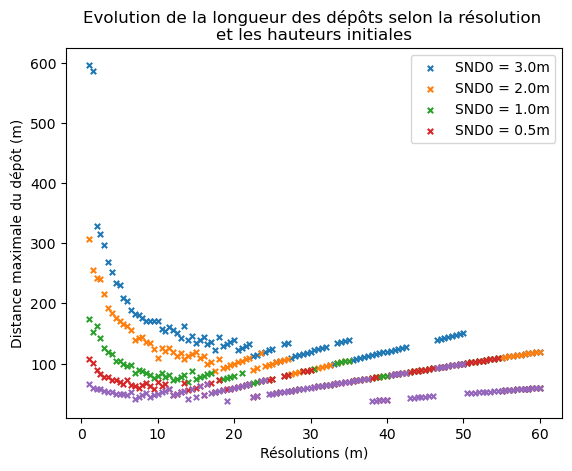

In [53]:
y0 = np.load(folder2 + "/fct_dist_resol_SND0.2.npy") 
y1 = np.load(folder2 + "/fct_dist_resol_SND0.5.npy") 
y2 = np.load(folder2 + "/fct_dist_resol_SND1.0.npy") 
y3 = np.load(folder2 + "/fct_dist_resol_SND2.0.npy")
y4 = np.load(folder2 + "/fct_dist_resol_SND3.0.npy")
plt.scatter(y4[0],y4[1],marker="x",s=15)
plt.scatter(y3[0],y3[1],marker="x",s=15)
plt.scatter(y2[0],y2[1],marker="x",s=15)
plt.scatter(y1[0],y1[1],marker="x",s=15)
plt.scatter(y0[0],y0[1],marker="x",s=15)
plt.xlabel('Resolutions (m)')
plt.ylabel('Maximal length of deposits (m)')
plt.title('Evolution of the maximal length deposit with resolution \net and initial heights',fontsize=12)
plt.legend(['SND0 = 3.0m','SND0 = 2.0m','SND0 = 1.0m','SND0 = 0.5m','SND0 = 0.2m'])
#plt.xlim(0.5,40)

On observe comme attendu que plus la hauteur initiale de neige est importante, plus le dépôt s’allonge dans le sens de la pente (résultat trivial). Cependant pour les résolutions inférieures à 10m, la variabilité des distances, si elle reste d’un facteur 2 en ordre de grandeur, prend des proportions plus importantes lorsque les quantités initiales sont importantes. Entre 1m et 10m de résolution on observe en effet pour les trois quantités initiales des dépôts variant d’un facteur deux en ordre de grandeur ce qui représente 50m pour SND0=0.5m, 100m pour SND0=1m et 180m pour SND0=2m. Il est alors intéressant d’essayer de déterminer un rapport SND0/résolution seuil à partir duquel on considère que les résultats proposés par Snowslide sont trop variables pour être acceptés. Par exemple on pourrait considérer qu’en augmentant la résolution d’un facteur 2, on souhaite un résultat qui ne varie pas d’une valeur supérieure à la résolution initiale. (Exemple pour deux DEM résolus à 10m et à 20m, on souhaite que la différence de distance de dépôts entre les deux résultats ne soit pas supérieure à 20m). Ce qu’on cherche à éviter, c’est à quantité initiale de neige (SND0) donnée, de dépasser le point d’inflexion où la courbe croît exponentiellement lorsqu’on augmente la résolution.

AJOUTER LE TRUC OU ON TROUVE LE RATIO

In [42]:
# Defining a linear regression function
def reg_lin(x,y,label={'x':'x','y':'y','label':'data','title':'Régression linéaire sur les données'}) :
    # importations
    import matplotlib.pyplot as plt
    import numpy as np

    # Effectuer la régression linéaire
    coefficients = np.polyfit(x, y, 1)
    p = np.poly1d(coefficients)

    # Créer un vecteur de valeurs prédites
    x_pred = np.linspace(min(x), max(x), 100)
    y_pred = p(x_pred)

    # Tracer les points et la régression linéaire
    plt.scatter(x, y, label=label['label'])
    plt.plot(x_pred, y_pred, color='red', label=f'Régression linéaire : {coefficients[0]:.2f}x + {coefficients[1]:.2f}')

    # Ajouter des étiquettes et la légende
    plt.xlabel(label['x'])
    plt.ylabel(label['y'])
    plt.title(label['title'])
    plt.legend()

    # Afficher le graphique
    plt.show()

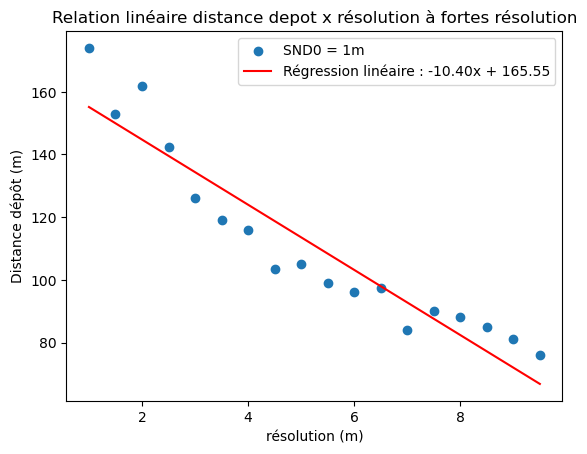

In [45]:
# Régression affine sur les points de résol - de 10m pour SND0 = 1m
points = y2[1][np.where(y2[0]<10)]
abs = y2[0][np.where(y2[0]<10)]
reg_lin(abs,points,label={'x':'résolution (m)','y':'Distance dépôt (m)','label':'SND0 = 1m','title':'Relation linéaire distance depot x résolution à fortes résolution'})

Il semblerait qu'on identifie systématiquement la même tendance. Celle-ci est décrite avec plus de précision dans le rapport. Mais on observe aux fortes résolutions une "explosion" exponentielle des distances de dépôt. Aux faibles résolutions en revanche les résultats sont moins significatifs et on peut postuler un faible impact de la résolution sur les simulations (elle restent confinées dans un intervalle d'incertitude...). Il est donc intéressant d'identifier pour une hauteur initiale de neige donnée, une résolution à partir de laquelle Snowslide ne peux plus fonctionner sans "sortir" de cet intervalle. 

De manière visuelle, on constate que les valeurs de distances "n'explosent" pas pour des résolutions supérieures à 10m (elles restent dans le même intervalle). On récupère donc la distance maximale correspondant à des simulations sur des résolutions inférieures. On détermine la résolution minimale à partir de laquelle on est au dessus de cette distance max. 

In [87]:
# On copie les données
résol = np.copy(y4[0])
lengths = np.copy(y4[1])

# On récupère la valeur moyenne et l'écart types de la série de longueurs de dépôts 
# uniquement pour les résolutions supérieures à 10m (on constate visuellement qu'au delà de 10m pas de significativité)
mean = np.mean(lengths[résol>10])
std = np.std(lengths[résol>10])
threshold = mean + 2*std

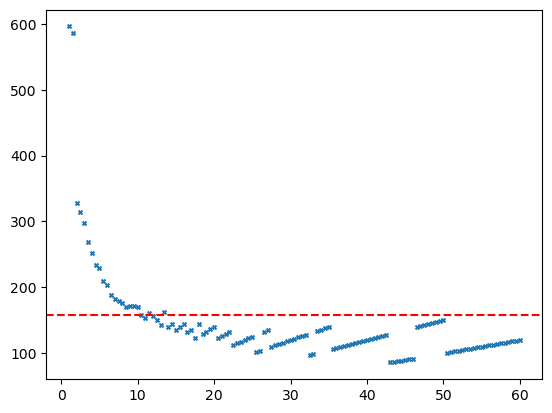

In [88]:
# On vérifie ce que ça veut dire pour le graphe ! 
plt.scatter(résol,lengths,marker="x",s=8)
plt.axhline(y=threshold, color='r', linestyle='--')

In [99]:
np.max(résol[lengths > threshold])

13.5

In [100]:
# On sélectionne dans les données dont la longueur est supérieure à threshold la résolution la plus grossière
np.max(résol[lengths > threshold])

13.5

Dans ce cas, on estime qu'avec une hauteur initiale de neige de 3m, la résolution ne peut théoriquement pas être supérieure à 13.5 m si on veut que Snowslide fonctionne correctment. Répétons l'expérience pour différentes hauteurs initiales et comparons les rapports snd0/résolution. 

In [106]:
# On copie les données
résol = np.copy(y0[0])
lengths = np.copy(y0[1])
threshold = np.mean(lengths[résol>10]) + 2*np.std(lengths[résol>10])
np.max(résol[lengths > threshold])

50.0

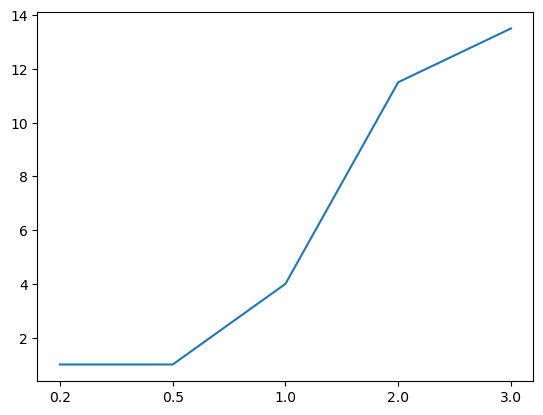

In [107]:
# On récupère alors les données suivantes
resol_max = [1,1,4.0,11.5,13.5]
hauteurs_init = ['0.2','0.5','1.0','2.0','3.0']
plt.plot(hauteurs_init,resol_max)

### 4) Validating the results on real dems

Dans les sciences glaciologiques, il se trouve qu’on travaille rarement avec des données de résolution supérieure à 10m. De plus, en se plaçant à des fréquences temporelles suffisamment élevées (mensuelles par exemple), il y a assez peu de chances que Snowslide initialise des hauteurs de neige supérieures à 2m donc on se situe presque systématiquement dans le domaine de validité de l’algorithme. Les figure 34 et 35 montrent les résultats de convergence sur le DEM du glacier de Talèfre.


In [38]:
folder3 = 'Real_dems'
if not os.path.exists(folder3):
    os.mkdir(folder3)

In [49]:
dem_path = "dem_talefre.tif"
res = [10,30,50,100]
dem_paths = []
for elt in res :
    # Creating path list 
    dst_path = folder3 + "/" + f"dem_talefre{elt}m.tif"
    dem_paths.append(dst_path)
    # generating dems
    factor=10/float(elt)
    resampling_dem(src_path=dem_path, dst_path=dst_path,factor=factor,resampling="bilinear")

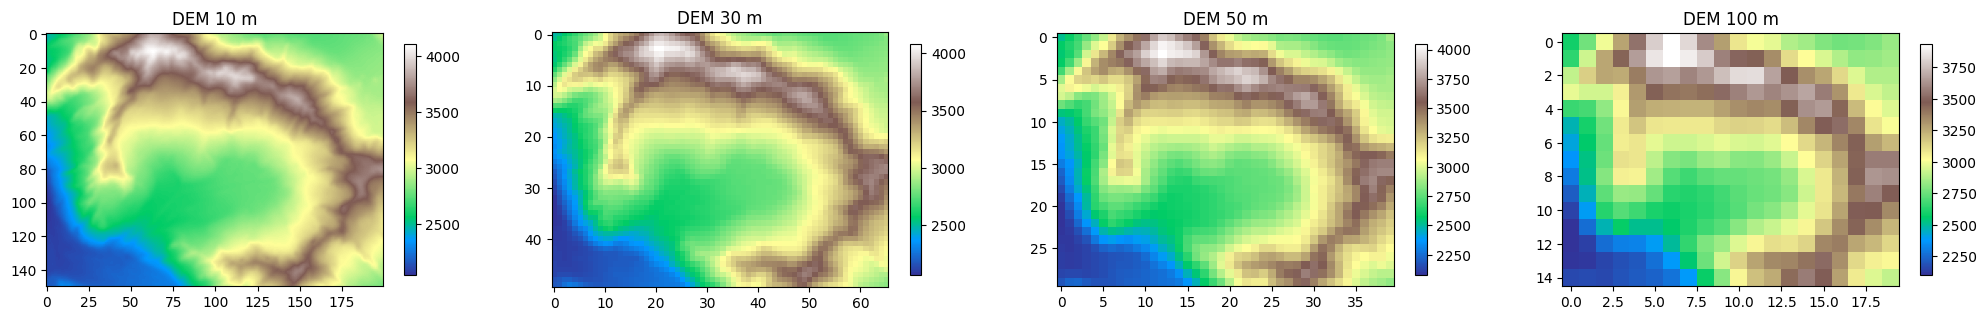

In [51]:
# Listing elements in the folder 
res = [10,30,50,100]
fig,ax = plt.subplots(1,4,figsize=(25,5))
for i in range(len(dem_paths)):
    dem = rasterio.open(dem_paths[i]).read(1)
    plot = ax[i].imshow(dem,cmap='terrain')
    plt.colorbar(plot,ax=ax[i],shrink=0.6)
    ax[i].set_title(f"DEM {res[i]} m")
#plt.suptitle('Digital elevation models of Talefre glacier with differents resolutions')

In [53]:
# Launching snowslide on these dems
statistics = []
snd_tot = []
snd_stat = []
i = 0
for dem_path in dem_paths :
    # Inputs
    init = 1.0
    dem = rasterio.open(dem_path).read(1)

    snd0 = np.zeros(np.shape(dem))
    snd0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True,"compute_edges":True}
    
    # Simulation
    snd = snowslide_base(dem_path,snd0,param_routing=param_routing)
    snd_tot.append(snd)

    # Statistiques
    dic = {}
    snd_test = np.copy(snd)
    snd_test[np.where(snd <= snd0)] = np.nan
    snd_stat.append(snd_test)
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(snd_test))*resolution**2
    dic["deposit_volume"] = np.nansum(snd_test)*resolution**2
    dic["max_height"] = np.nanmax(snd_test)
    indices_non_nan = np.where(~np.isnan(snd_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    statistics.append(dic)
    i = i+1
    print(f"##### Complété : {(i/4)*100}%")

/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 25.0%


/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 50.0%


/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 75.0%
##### Complété : 100.0%


/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/snowslide/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


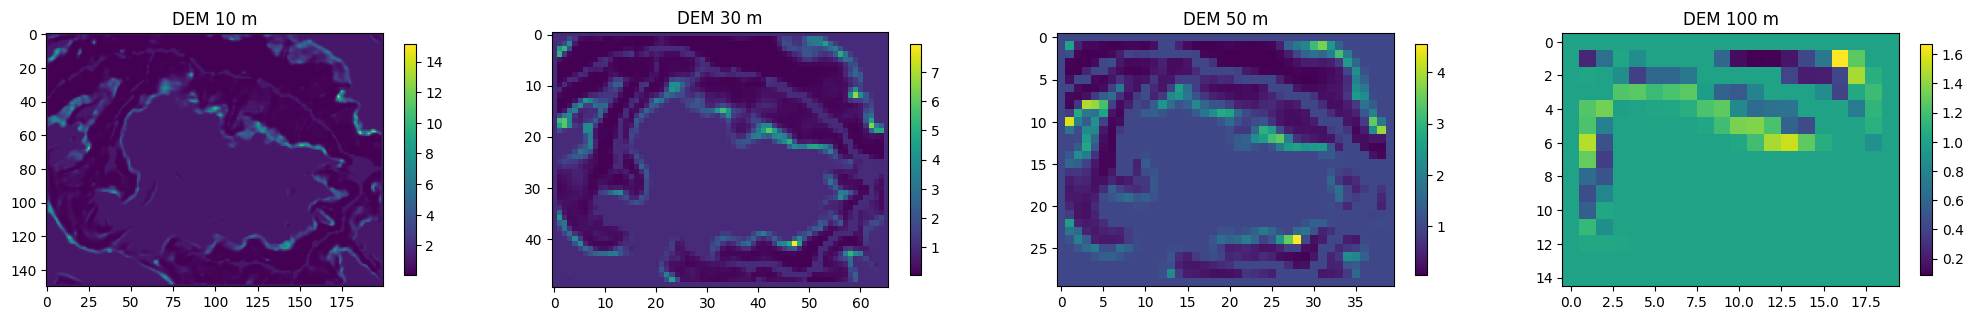

In [55]:
# Plotting code
fig,ax = plt.subplots(1,4,figsize=(25,5))
for i in range(4) :
    plot = ax[i].imshow(snd_tot[i])
    plt.colorbar(plot,ax=ax[i],shrink=0.6)
    ax[i].set_title(f"DEM {res[i]} m")

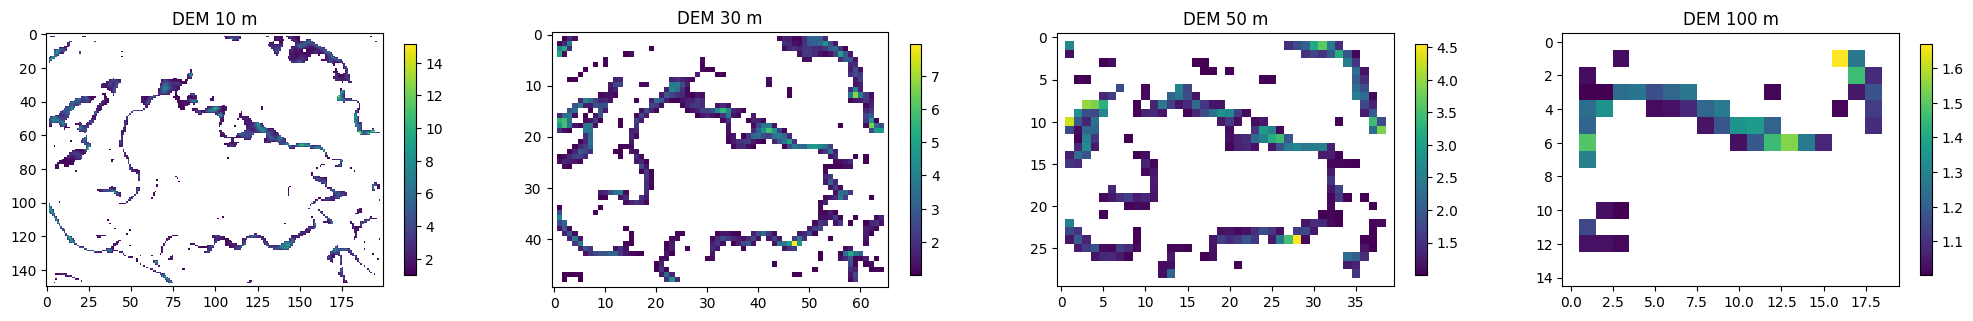

In [56]:
fig,ax = plt.subplots(1,4,figsize=(25,5))
for i in range(4) :
    plot = ax[i].imshow(snd_stat[i])
    plt.colorbar(plot,ax=ax[i],shrink=0.6)
    ax[i].set_title(f"DEM {res[i]} m")

Text(0, 0.5, 'Heights (m)')

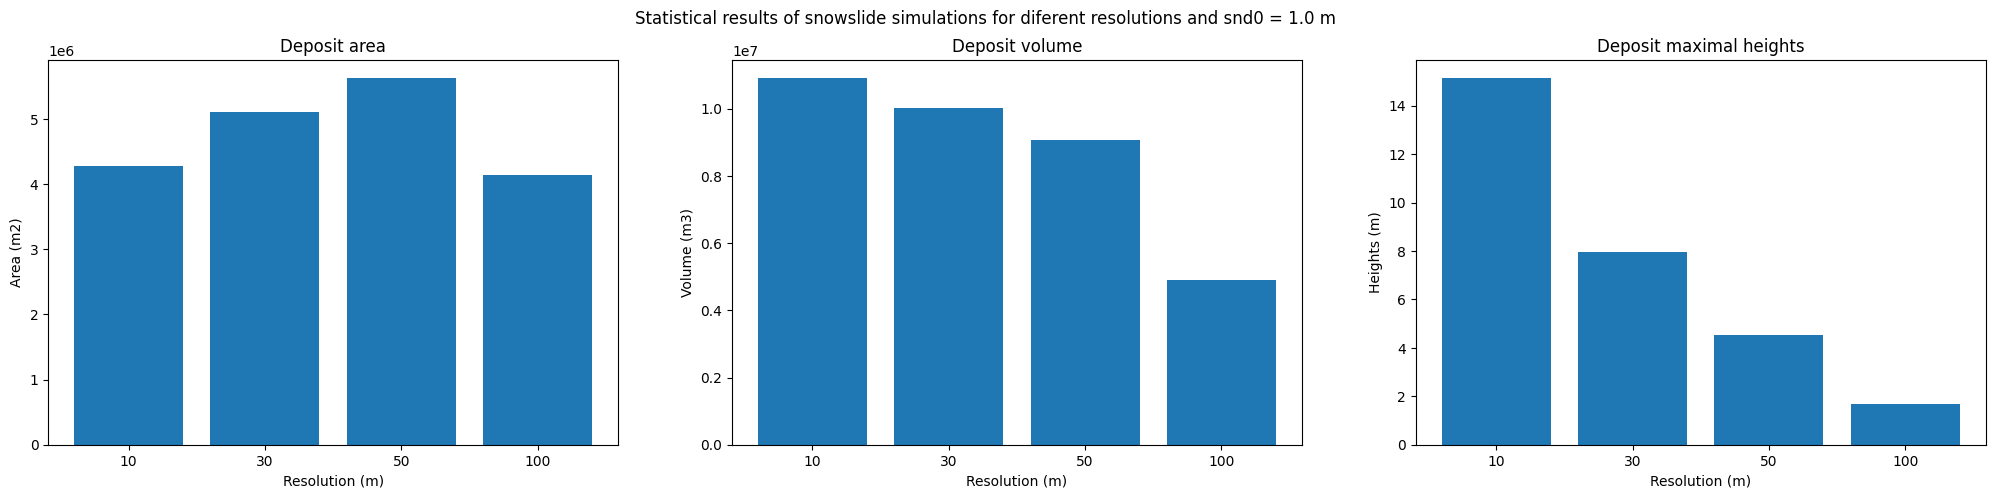

In [59]:
areas = []
volumes = []
heights = []
resol_dems = ['10','30','50','100']
for i in range(len(dem_paths)):
    dem = rasterio.open(dem_paths[i]).read(1)
    res = rasterio.open(dem_paths[i]).res
    # SND0 = np.full(np.shape(dem),1.0)
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])

fig,ax = plt.subplots(1,3,figsize=(25,5))
plt.suptitle(f"Statistical results of snowslide simulations for diferent resolutions and snd0 = {init} m")
ax[0].bar(resol_dems,areas)
ax[0].set_title('Deposit area')
ax[0].set_xlabel('Resolution (m)')
ax[0].set_ylabel('Area (m2)')
ax[1].bar(resol_dems,volumes)
ax[1].set_title('Deposit volume')
ax[1].set_xlabel('Resolution (m)')
ax[1].set_ylabel('Volume (m3)')
ax[2].bar(resol_dems,heights)
ax[2].set_title('Deposit maximal heights')
ax[2].set_xlabel('Resolution (m)')
ax[2].set_ylabel('Heights (m)')

Text(0, 0.5, 'Deviation from average')

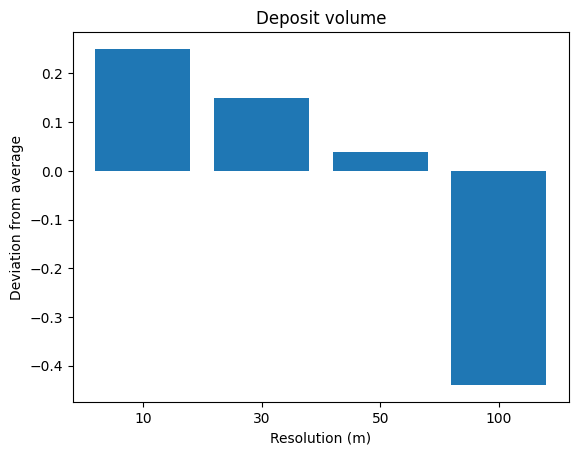

In [60]:
vol = np.array(volumes)
mean = np.mean(vol)
vol = (vol-mean)/mean

plt.bar(resol_dems,vol)
plt.title('Deposit volume')
plt.xlabel('Resolution (m)')
plt.ylabel('Deviation from average')

On constate visuellement que les résultats sont assez similaires pour les quatre résolutions sauf quand celle-ci est trop dégradée (dem à 100m). On obtient aussi quelques résultats statistiques associés à ces simulations. Les valeurs semblent montrer que l’utilisation de résolutions différentes entre 10 et 100 m n’affectent pas de façon très significative les résultats de simulation. Comme précédemment on considère comme appartenant à un dépôt tout pixel ayant une valeur strictement supérieure à sa valeur initiale (ici 1m). L’aire des dépôts augmente logiquement avec des résolutions plus grossières mais comme les hauteurs maximales diminuent on se retrouve avec des volumes dans les zones de dépôts d’ordres de grandeur similaires. Si l’on calcule l’écart relatif à la moyenne pour ces volumes là on retrouve des différences maximales de l’ordre de 6% ce qui est effectivement négligeable dans ce type de modélisations. On accepte donc dans les cas réels que la résolution a un impact contrôlable si ce n’est négligeable sur les sorties du modèle.

___________
### ANCIEN TRAVAIL : pour le rapport

L'objectif ensuite est d'afficher un graphique qui distingue la variabilité des résultats en fonction d'un indicateur. Quelques chose qui permette d'évaluer un indicateur seuil à partir duquel les résultats sont trop variables...

In [183]:
# Calcul de la variance, moyenne et écart types des résultats pour SND0 = 1m
data = np.copy(y3[1])
print("La moyenne est : ", np.mean(data)) 
print("La variance est : ", np.var(data))
print("L'écart type est : ", np.std(data))

La moyenne est :  111.40756302521008
La variance est :  1423.2477579266995
L'écart type est :  37.725956024025415


Ce qu'on va faire c'est qu'on va récupérer les données à chaque quantité initiale : 
- on va les classer par ordre de résolution croissante (de 60m à 1m)
- on va déterminer un sous groupe de référence et on va ajouter à ce groupe successivement une valeur de distance associée à une résolution grande au groupe et calculer la déviation standard qu'on retient. 
- Puis on affiche sur un graphe la déviation standard avec la résolution maximale du groupe. 
- A qté initiale donnée, on détermine à quelle résolution la déviation standard commence à déconner.

In [206]:
# # On classe dans l'ordre
# abscisses = y4[0]
# valeurs = y4[1]

# # Regrouper les paires d'abscisses et de valeurs
# paires = list(zip(abscisses, valeurs))

# # Trier les paires en fonction des abscisses
# paires_triees = sorted(paires, key=lambda x: x[0])

# # Séparer les abscisses et les valeurs triées
# abscisses_triees, valeurs_triees = zip(*paires_triees)

# # Afficher les données triées
# print(abscisses_triees)
# print(valeurs_triees)

# array = np.array([abscisses_triees,valeurs_triees])
# np.save("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND3sorted.npy",array)

In [208]:
data1 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.2sorted.npy")
data2 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.5sorted.npy")
data3 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND1sorted.npy")
data4 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND2sorted.npy")
data5 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND3sorted.npy")

(0.0, 62.95)

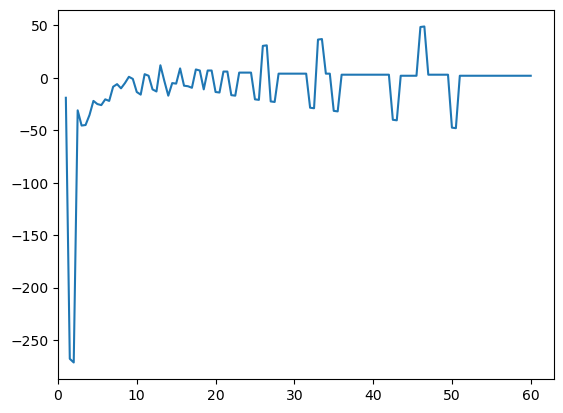

In [238]:
#plt.plot(data1[0],np.gradient(data1[1],data1[0]))
#plt.plot(data2[0],np.gradient(data2[1],data2[0]))
#plt.plot(data3[0],np.gradient(data3[1],data3[0]))
#plt.plot(data4[0],np.gradient(data4[1],data4[0]))
plt.plot(data5[0],np.gradient(data5[1],data5[0]))
# plt.legend(['SND0=0.2','SND0=0.5','SND0=1','SND0=2','SND0=3'])
plt.xlim(0)

Text(0.5, 1.0, 'Seuil maximal SND0/résolution')

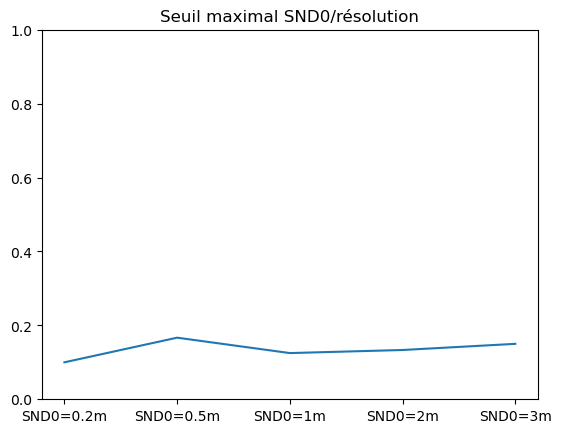

In [246]:
# Il en résulte les ratios :
values = [0.2/2,0.5/3,1/8,2/15,3/20]
plt.plot(['SND0=0.2m','SND0=0.5m','SND0=1m','SND0=2m','SND0=3m'],values)
plt.ylim(0,1)
plt.title('Seuil maximal SND0/résolution')

##### If needed, a code to delete the data created

In [61]:
# If needed, a code to delete the data created
f_path = [folder,folder2,folder3]
for f in f_path:
    files = os.listdir(f)
    for x in files:
        os.remove(f + "/" + x)
    os.rmdir(f)

___

### Affichage et comparaison de profils de dépôt

In [248]:
# On liste les éléments du dossier 
import os
a = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_1.0m.tif"
b = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_2.0m.tif"
c = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_5.0m.tif"
d = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_10m.tif"
e = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_30.0m.tif"
f = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_50.0m.tif"
dem_paths = [a,b,c,d,e,f]

# On lance snowslide sur ces DEMs
statistics = []
SND_tot = []
i = 0
for dem_path in dem_paths :
    # Inputs
    init = 1.0
    dem = rasterio.open(dem_path).read(1)

    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SND_tot.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    statistics.append(dic)
    i = i+1
    print(f"##### Complété : {(i/120)*100}%")

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 0.8333333333333334%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 1.6666666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 2.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 3.3333333333333335%
##### Complété : 4.166666666666666%
##### Complété : 5.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


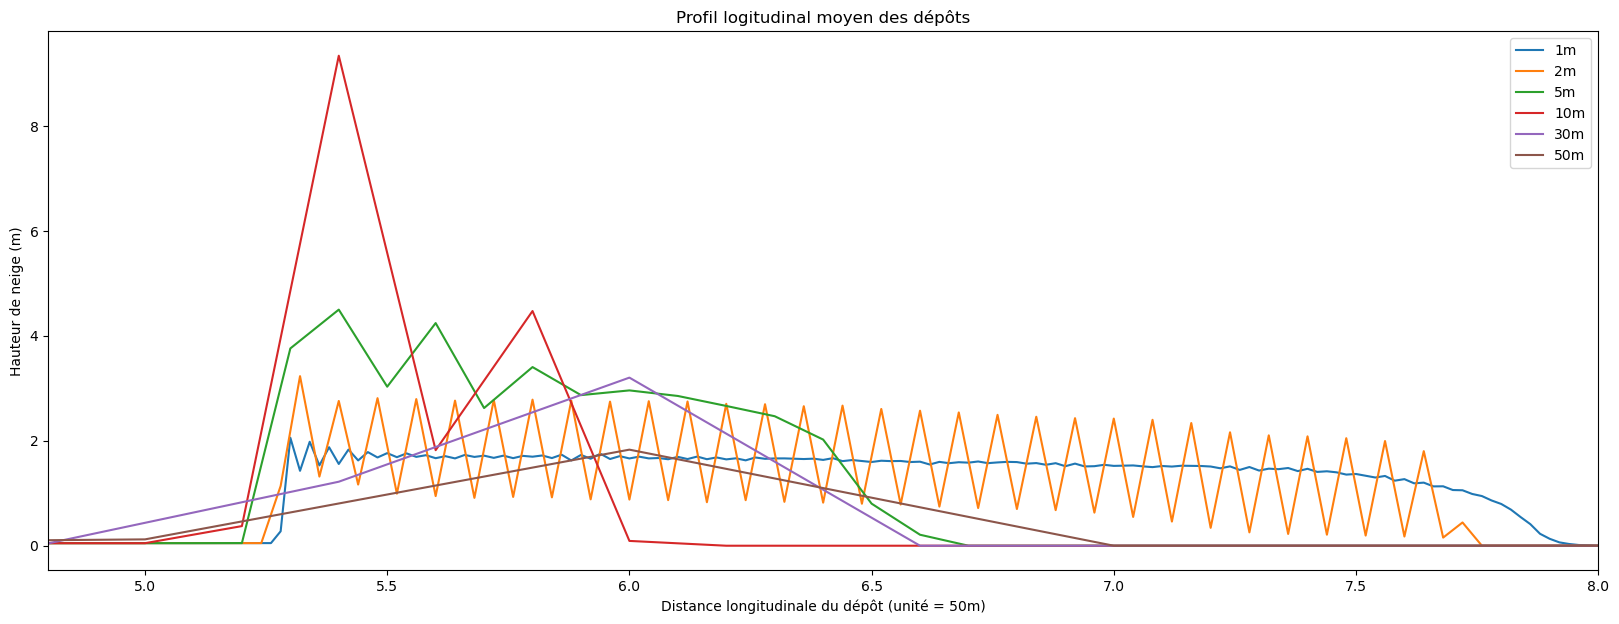

In [294]:
profils=[]
factors=[50,25,10,5,5/3,1]
plt.figure(figsize=(20,7))
for i in range(len(SND_tot)) :
    S = SND_tot[i]
    profil = np.mean(S,axis=1)
    #test = profil[np.where(profil>1)]
    #profils.append(test)
    plt.plot(np.arange(len(SND_tot[i]))/factors[i],profil)
    plt.legend(['1m','2m','5m','10m','30m','50m'])
    plt.xlim(4.8,8)
    plt.title("Profil logitudinal moyen des dépôts")
    plt.xlabel('Distance longitudinale du dépôt (unité = 50m)')
    plt.ylabel('Hauteur de neige (m)')
